In [4]:
import os
! git clone https://github.com/mwl10/hetvae
os.chdir('/content/hetvae')
! pip install -r requirements.txt
os.chdir('/content/hetvae/src')
import numpy as np
import torch
import torch.optim as optim
import models
import utils
import my_utils
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline


Cloning into 'hetvae'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (73/73), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 73 (delta 25), reused 62 (delta 17), pack-reused 0
Unpacking objects: 100% (73/73), done.


In [ ]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [23]:
! pwd

/content/hetvae/src


In [24]:
lc_files = glob('/content/hetvae/data/*/*')

In [44]:
lcs = my_utils.file_to_np(*lc_files)
# want to normalize across individual light curves...
# also normalize time in each light curve: each one should start at zero
lcs = [lc[:,:2] for lc in lcs] # get rid of error bars for right now
# how do we pass the light curves in?
# what is union time points? is it the regularly spaced output points that we want on all the light curves? 
# zero fill the values up until the longest light curve, or set a boundry of length
# what do we do about the time values then? have them zero as well? 

dims of /content/hetvae/data/EDELSON/NGC4593_W1.dat:	(150, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_M2.dat:	(248, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_SX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_W2.dat:	(147, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_HX.dat:	(190, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W2.dat:	(259, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_HX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_W1.dat:	(260, 3)
dims of /content/hetvae/data/EDELSON/NGC5548_SX.dat:	(267, 3)
dims of /content/hetvae/data/EDELSON/NGC4593_M2.dat:	(148, 3)
dims of /content/hetvae/data/KOSHIDA/NGC5548_K.dat:	(310, 3)
dims of /content/hetvae/data/KOSHIDA/NGC4593_V.dat:	(34, 3)
dims of /content/hetvae/data/KOSHIDA/NGC4593_K.dat:	(36, 3)
dims of /content/hetvae/data/KOSHIDA/NGC5548_V.dat:	(301, 3)
dims of /content/hetvae/data/DEROSA/NGC5548_Cont.dat:	(177, 3)
dims of /content/hetvae/data/DEROSA/NGC5548_Emis.dat:	(105, 3)


In [47]:
# set starting time value to zero 
#lcs = [lc[:,0] - lc[0,0] for lc in lcs]
#print(lcs[0].shape, lcs[1].shape)
for lc in lcs:
  lc[:,0] = lc[:,0] - lc[0,0]

In [48]:
# flux values are sort of already fine
# can normalize time though 
# zero fill each column up to the max length lc, which is 310 here, ohhh, need to make each time array as union time and put zeros where there aren't 
# values for that time...



array([[ 0.     ,  1.386  ],
       [ 0.1321 ,  1.403  ],
       [ 0.19876,  1.374  ],
       [ 0.26532,  1.338  ],
       [ 0.3328 ,  1.375  ],
       [ 0.40069,  1.347  ],
       [ 0.47645,  1.345  ],
       [ 0.539  ,  1.341  ],
       [ 0.61146,  1.331  ],
       [ 0.68214,  1.364  ],
       [ 0.79656,  1.424  ],
       [ 0.99686,  1.319  ],
       [ 1.06381,  1.377  ],
       [ 1.13027,  1.329  ],
       [ 1.19563,  1.3    ],
       [ 1.3302 ,  1.286  ],
       [ 1.39752,  1.347  ],
       [ 1.46242,  1.287  ],
       [ 1.60225,  1.282  ],
       [ 1.6793 ,  1.346  ],
       [ 1.79287,  1.29   ],
       [ 2.19285,  1.294  ],
       [ 2.25939,  1.252  ],
       [ 2.45837,  1.251  ],
       [ 2.52435,  1.278  ],
       [ 2.6026 ,  1.272  ],
       [ 2.67618,  1.336  ],
       [ 2.78998,  1.267  ],
       [ 2.85687,  1.22   ],
       [ 2.92679,  1.25   ],
       [ 2.98976,  1.251  ],
       [ 3.12315,  1.236  ],
       [ 3.25567,  1.225  ],
       [ 3.3883 ,  1.207  ],
       [ 3.672

## Setting up arguments

In [ ]:
args = Namespace(batch_size=16, bound_variance=True, const_var=False, dataset='toy', dropout=0.0, 
                 elbo_weight=1.0, embed_time=128, enc_num_heads=1, intensity=True, k_iwae=1, kl_annealing=False, 
                 kl_zero=False, latent_dim=64, lr=0.0001, mixing='concat', mse_weight=0.0, n=2000, net='hetvae', 
                 niters=2000, norm=True, normalize_input='znorm', num_ref_points=16, rec_hidden=16, recon_loss=False, 
                 sample_tp=0.5, save=True, seed=0, shuffle=True, std=0.1, var_per_dim=False, width=512)

In [ ]:
seed = args.seed
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed(seed)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## **Generating Synthetic Data**

In [ ]:
data_obj = utils.get_synthetic_data(args)
train_loader = data_obj["train_dataloader"]
test_loader = data_obj["test_dataloader"]
val_loader = data_obj["val_dataloader"]
gt = data_obj['ground_truth']
dim = data_obj["input_dim"]
union_tp = utils.union_time(train_loader)

(2000, 51, 3)
(1600, 51, 3) (320, 51, 3) (400, 51, 3)


In [ ]:
# how do we even want to handle the data? 
# this notebook just loads regularly sequenced data and drops points...

In [ ]:
trainb1 = next(iter(train_loader))
print(trainb1.shape)
# sure we need 

torch.Size([16, 51, 3])


51

## **Loading HeTVAE model**

In [ ]:
net = models.load_network(args, dim, union_tp) # dim = 1
params = list(net.parameters())
optimizer = optim.Adam(params, lr=args.lr)

tensor([ 0.4388,  0.6020,  0.5384,  0.1893,  0.4195,  0.1291,  0.2605, -0.0621,
         0.0885, -0.0871, -0.1214, -0.0931,  0.0824,  0.0346,  0.6134,  0.6173,
         1.0480,  1.1167,  1.2295,  1.3869,  1.4415,  1.4563,  1.6237,  1.6861,
         1.7124,  1.5276,  1.6492,  1.6088,  1.4651,  1.4383,  1.3877,  1.5126,
         1.0024,  1.1388,  0.8449,  0.6703,  0.6210,  0.3618,  0.4003,  0.5697,
         0.5497,  0.7182,  1.0684,  1.3480,  1.4479,  1.3320,  1.2083,  0.7613,
         0.5220,  0.1652, -0.1256])


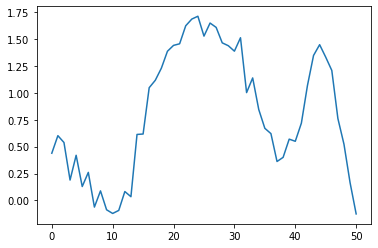

In [ ]:
# 
plt.plot(trainb1[0,:,0])
print(trainb1[0:,0])

## **Training**

In [ ]:
for itr in range(1, args.niters + 1):
      train_loss = 0
      train_n = 0
      avg_loglik, avg_kl, mse, mae = 0, 0, 0, 0
      for train_batch in train_loader:
          batch_len = train_batch.shape[0] 
          train_batch = train_batch.to(device)
          subsampled_mask = torch.zeros_like(
              train_batch[:, :, dim:2 * dim]).to(device) # mask is 128,51,1
          seqlen = train_batch.size(1) # 51
          
          for i in range(batch_len):
              length = np.random.randint(low=3, high=10) # 3-9 
              obs_points = np.sort(  # random choice from 0-50 of random length 3-9, 
                  np.random.choice(np.arange(seqlen), size=length, replace=False)
              ) 
              subsampled_mask[i, obs_points, :] = 1 # set those particular points to 1, others are still zero 
          recon_mask = train_batch[:, :, dim:2 * dim] - subsampled_mask # the opposite of subsampled mask essentially 0s where the 1s are
          # keep only 3-9 points for each time series for each batch dunno why you need the mask too 
          context_y = torch.cat((
              train_batch[:, :, :dim] * subsampled_mask, subsampled_mask
          ), -1)
          break 

          loss_info = net.compute_unsupervised_loss(
              train_batch[:, :, -1],
              context_y,
              train_batch[:, :, -1],
              torch.cat((
                  train_batch[:, :, :dim] * recon_mask, recon_mask
              ), -1),
              num_samples=args.k_iwae,
              beta=1,
          )
          optimizer.zero_grad()
          loss_info.composite_loss.backward()
          optimizer.step()
          train_loss += loss_info.composite_loss.item() * batch_len
          avg_loglik += loss_info.loglik * batch_len
          avg_kl += loss_info.kl * batch_len
          mse += loss_info.mse * batch_len
          mae += loss_info.mae * batch_len
          train_n += batch_len
      if itr % 100 == 0:
          print(
              'Iter: {}, train loss: {:.4f}, avg nll: {:.4f}, avg kl: {:.4f}, '
              'mse: {:.6f}, mae: {:.6f}'.format(
                  itr,
                  train_loss / train_n,
                  -avg_loglik / train_n,
                  avg_kl / train_n,
                  mse / train_n,
                  mae / train_n
              )
          )
          for loader, num_samples in [(val_loader, 5), (test_loader, 100)]:
              utils.evaluate_hetvae(
                  net,
                  dim,
                  loader,
                  0.5,
                  shuffle=False,
                  k_iwae=num_samples,
                  model_name=args.net,
              )

## **Vizualization with increasing number of observations**

In [ ]:
def viz(test_loader, k_iwae=1, n_max=20):
    pred_mean, pred_std = [], []
    masks = []
    targets = []
    tp =[]
    np.random.seed(0)
    with torch.no_grad():
        for low in [3, 10, 20]:
            for batch in test_loader:
                batch_len = batch.shape[0]
                batch = batch.to(device)
                subsampled_mask = torch.zeros_like(batch[:, :, dim:2 * dim]).to(device)
                seqlen = batch.size(1)
                for i in range(batch_len):
                    length = np.random.randint(low=low, high=low + 1)
                    obs_points = np.sort(np.random.choice(np.arange(seqlen), size=length, replace=False))
                    subsampled_mask[i, obs_points, :] = 1
                recon_mask = batch[:, :, dim:2 * dim] - subsampled_mask
                context_y = torch.cat((batch[:, :, :dim] * subsampled_mask, subsampled_mask), -1)
                px, _ = net.get_reconstruction(batch[:, :, -1], context_y, batch[:, :, -1], num_samples=k_iwae)
                pred_mean.append(px.mean.cpu().numpy())
                pred_std.append(torch.exp(0.5 * px.logvar).cpu().numpy())
                targets.append((batch[:, :, :dim]).cpu().numpy())
                masks.append(subsampled_mask.cpu().numpy())
                tp.append(batch[:, :, -1].cpu().numpy())
                if len(tp) % (n_max // 5) == 0:
                    break
    
    pred_mean = np.concatenate(pred_mean, axis=1)
    pred_std = np.concatenate(pred_std, axis=1)
    targets = np.concatenate(targets, axis=0)
    masks = np.concatenate(masks, axis=0)
    tp = np.concatenate(tp, axis=0)
    inputs = np.ma.masked_where(masks < 1., targets)
    print(pred_mean.shape, pred_std.shape, targets.shape, masks.shape, tp.shape)
    preds = np.random.randn(k_iwae // 2, k_iwae, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3]) * pred_std + pred_mean
    preds = preds.reshape(-1, pred_mean.shape[1], pred_mean.shape[2], pred_mean.shape[3])
    median = preds.mean(0) #np.quantile(preds, 0.5, axis=0)
    quantile2 = np.quantile(preds, 0.841, axis=0)
    quantile1 = np.quantile(preds, 0.159, axis=0)

    w = 2.0
    for index in range(n_max):
        plt.figure(figsize=(12, 1.5))
        for j in range(3):
            plt.subplot(1, 3, j + 1)
            plt.fill_between(tp[n_max * j + index], quantile1[n_max * j + index, :, 0], quantile2[n_max * j + index, :, 0], alpha=0.6, facecolor='#65c9f7', interpolate=True)
            plt.plot(tp[n_max * j + index], median[n_max * j + index, :, 0], c='b', lw=w, label='Reconstructions')
            plt.plot(tp[n_max * j + index], gt[index], c='r', lw=w, label='Ground Truth')
            plt.scatter(tp[n_max * j + index], inputs[n_max * j + index, :, 0], c='k', lw=w, label='Observed Data')
            plt.xlim([0, 1])
            plt.xticks([])
            plt.yticks([])
            if j == 1 and index == 0:
                plt.legend(loc='upper center', ncol=3, bbox_to_anchor=(0.6,1.5))
            
        plt.show()

(100, 60, 51, 1) (100, 60, 51, 1) (60, 51, 1) (60, 51, 1) (60, 51)


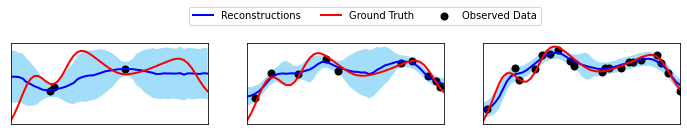

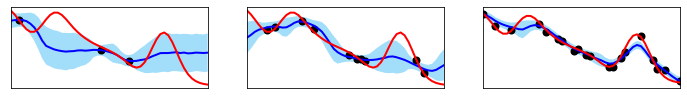

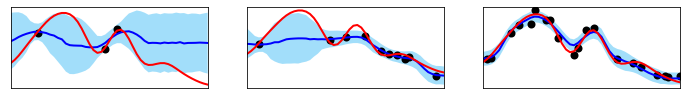

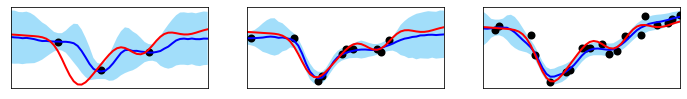

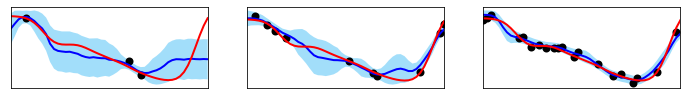

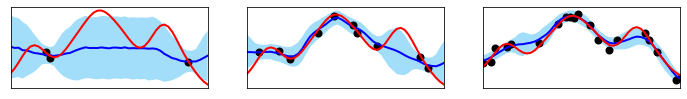

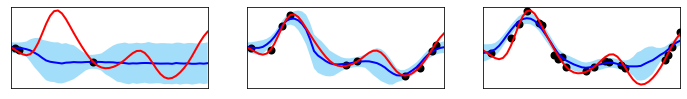

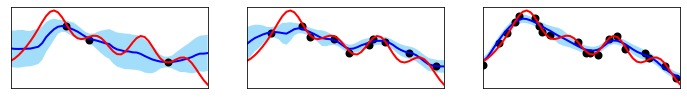

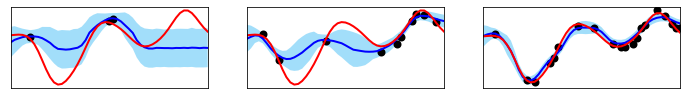

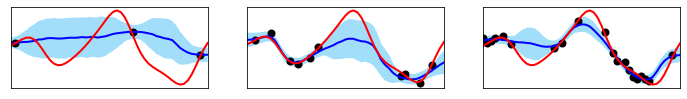

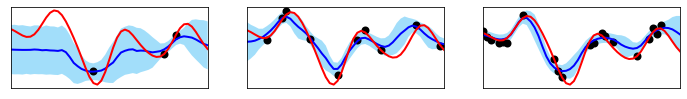

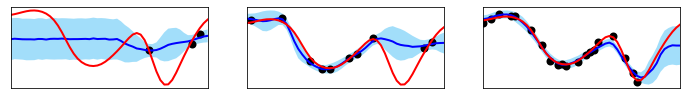

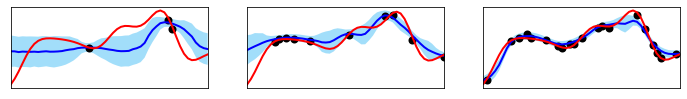

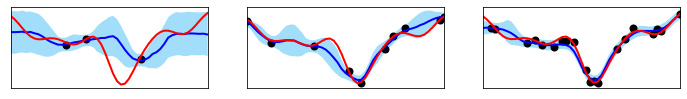

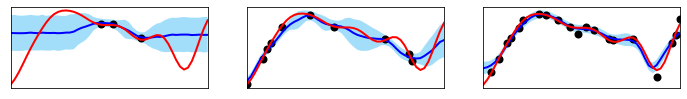

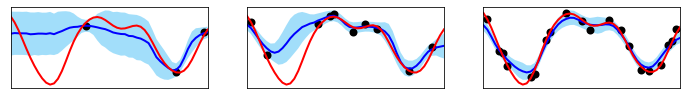

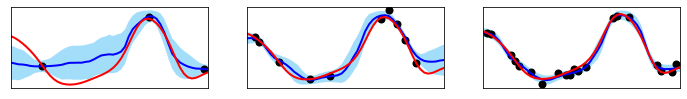

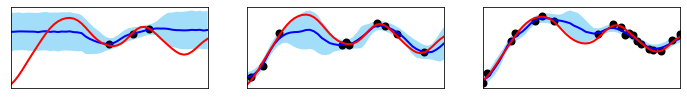

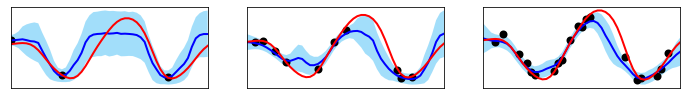

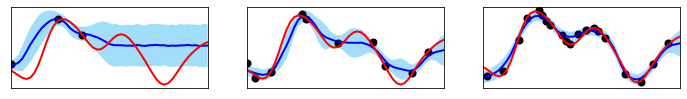

In [ ]:
viz(test_loader, k_iwae=100)